In [189]:
import pandas as pd
import numpy as np
import pymc3 as pm
from scipy import stats
import matplotlib.pyplot as plt
import arviz as az

In [190]:
# Generate some fake survival data for high LET radiation (large alpha beta ratio) to act as the observed data for the likelihood. 

np.random.seed(120)
points=500
ex=np.random.random_sample(500)*8
a=stats.beta(2.76,3).rvs(size=points)
b=stats.beta(0.14,7).rvs(size=points)
ey=np.exp(-(a*ex+b*ex**2))

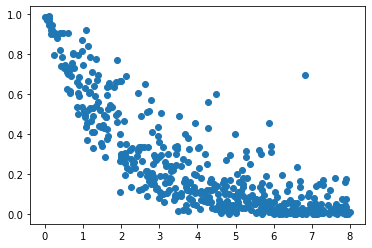

In [191]:
plt.scatter(ex,ey)

In [192]:
with pm.Model() as survival_model:
    # Hyperparameters
    scale_alpha = pm.HalfCauchy('scale_alpha', beta=1.0)
    scale_beta = pm.HalfCauchy('scale_beta', beta=1.0)
    # Priors on the alpha, beta in LQ model
    alpha = pm.HalfNormal('alpha', sd=scale_alpha, testval=0.5)
    beta = pm.HalfNormal('beta', sd=scale_beta, testval=0.5)
    epsilon=pm.HalfCauchy("epsilon", beta=1.0)
    # likelihood
    y_est=pm.Normal("y_est", mu=np.exp(-(alpha*ex+beta*ex**2)), sd=epsilon, observed=ey)
    step=pm.Metropolis()
    trace=pm.sample(draws=25000,step=step,tune=2000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [scale_beta]
>Metropolis: [scale_alpha]


Sampling 4 chains for 2_000 tune and 25_000 draw iterations (8_000 + 100_000 draws total) took 221 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [193]:
inference_data = az.from_pymc3(trace)

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017E0898B160>,
      dtype=object)

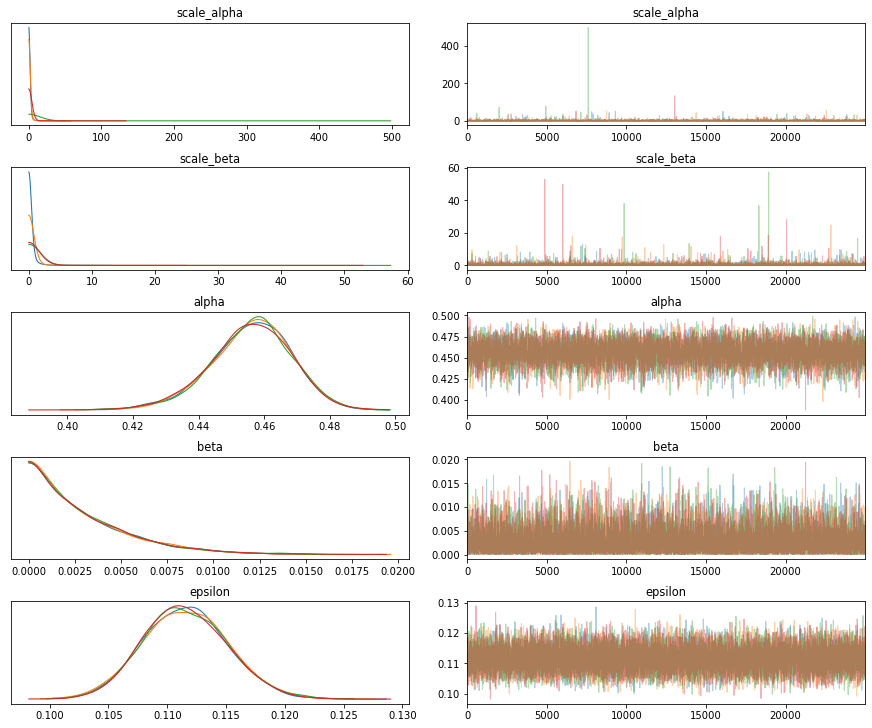

In [194]:
az.plot_trace(inference_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017E08616BE0>,
      dtype=object)

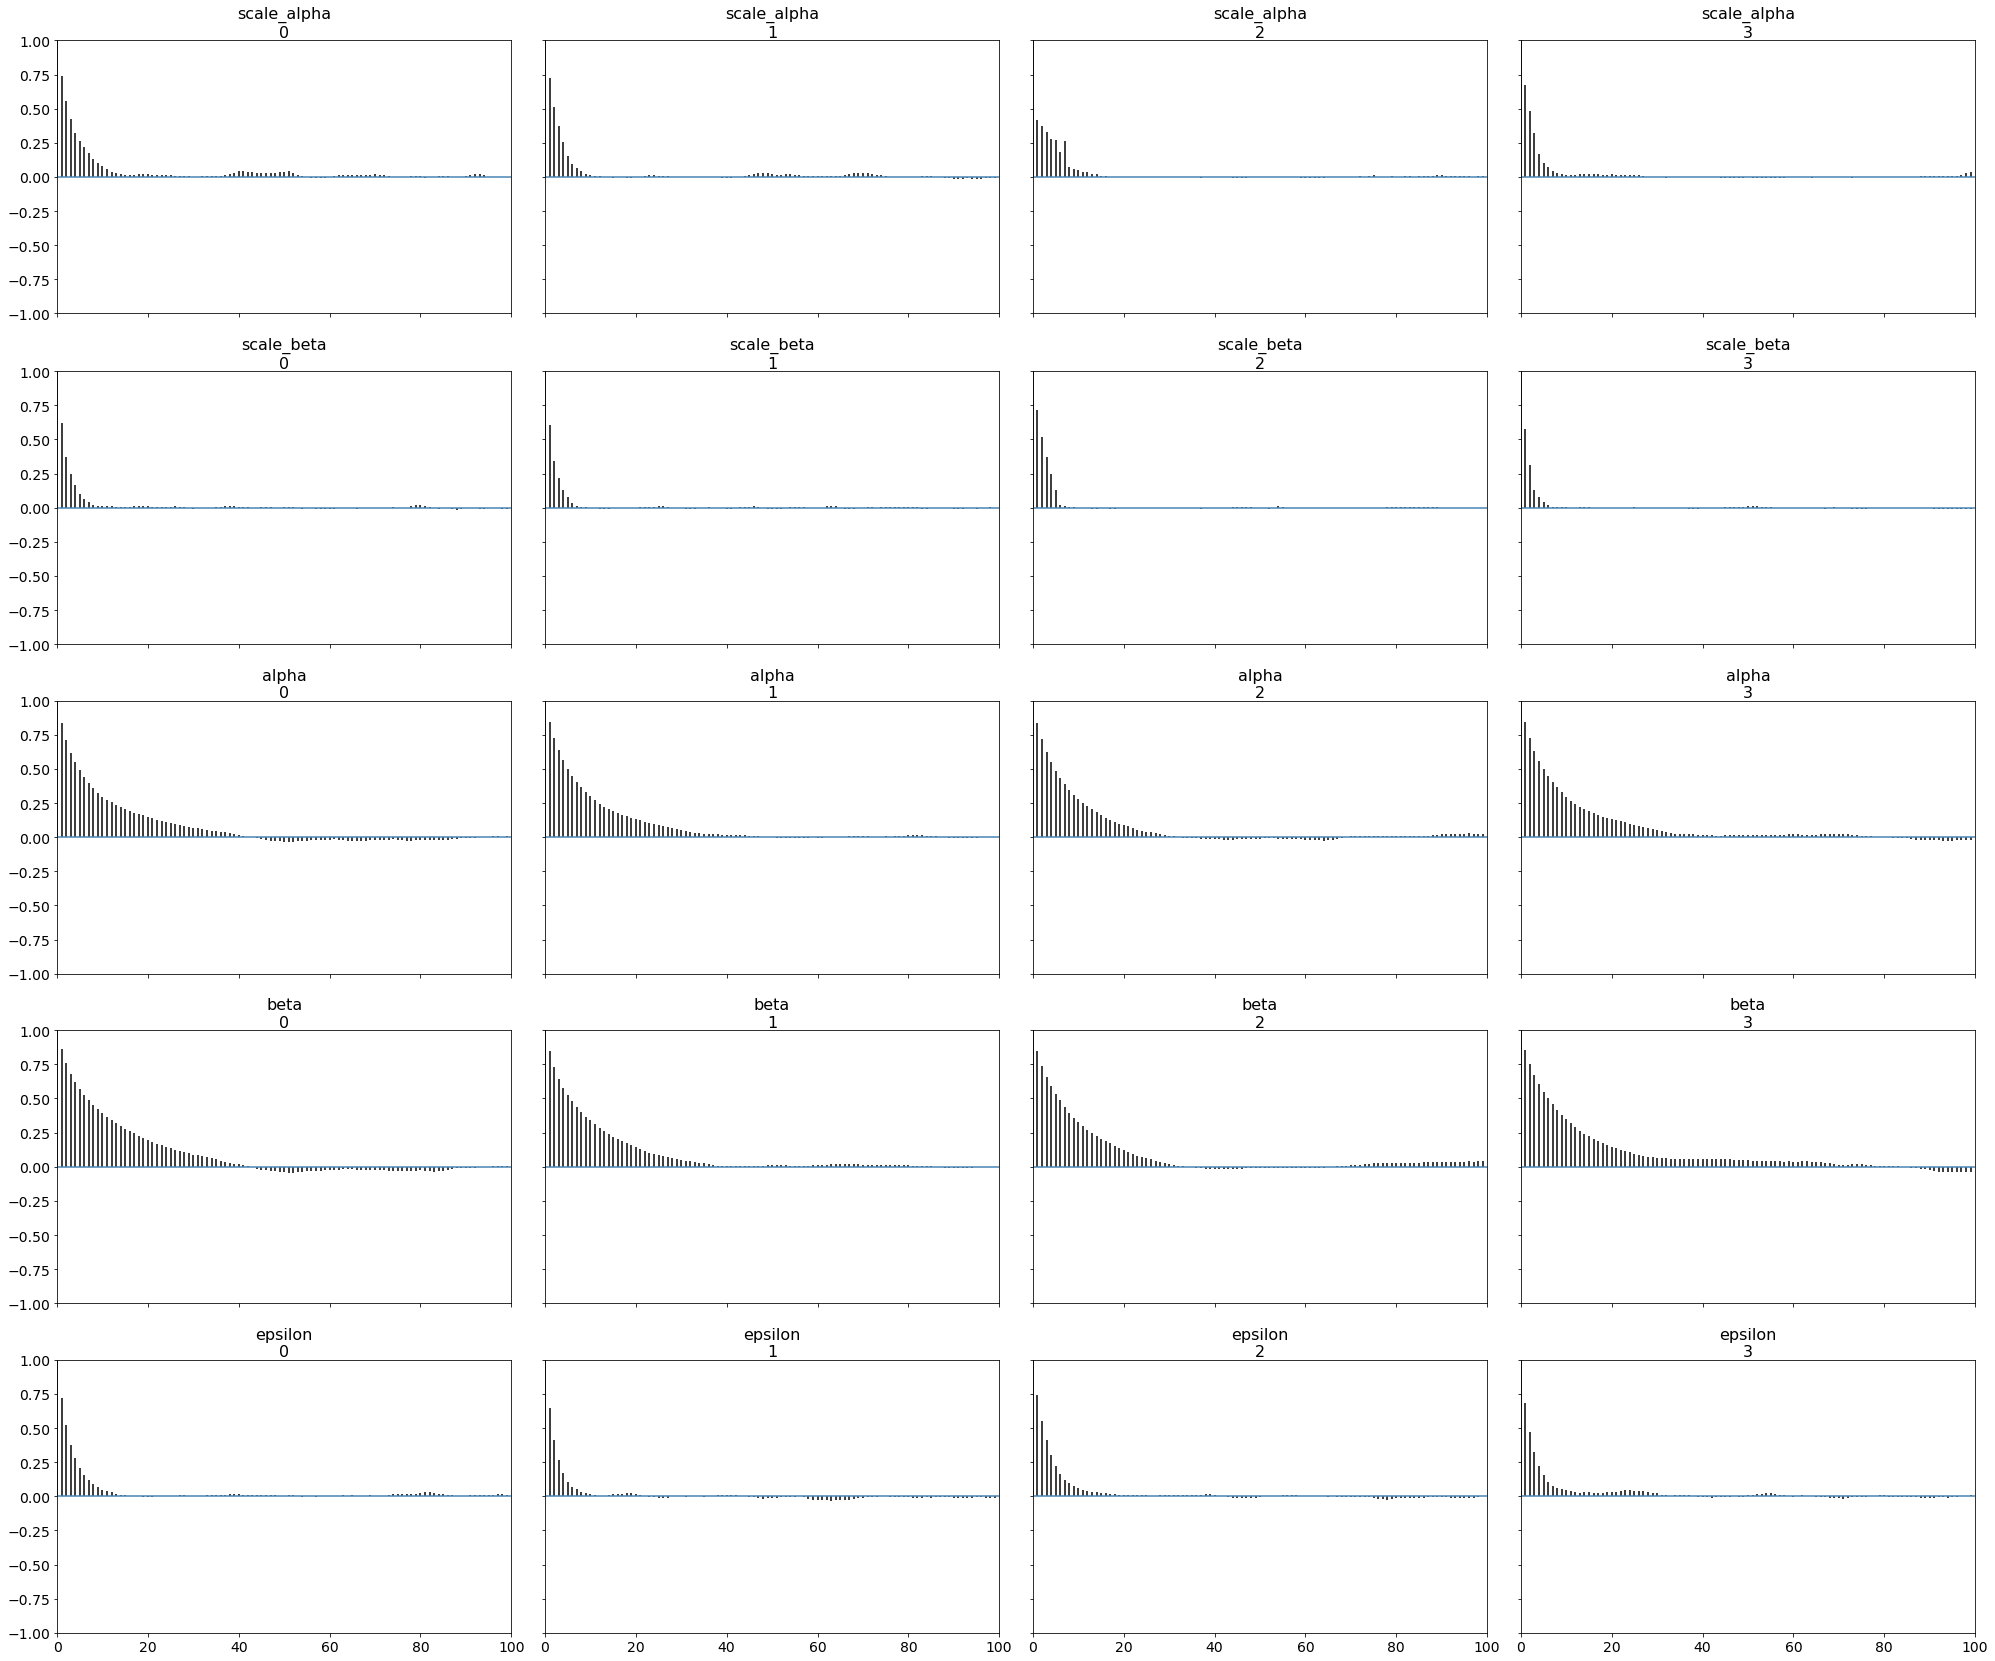

In [195]:
az.plot_autocorr(inference_data)

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017E22072EB0>],
      dtype=object)

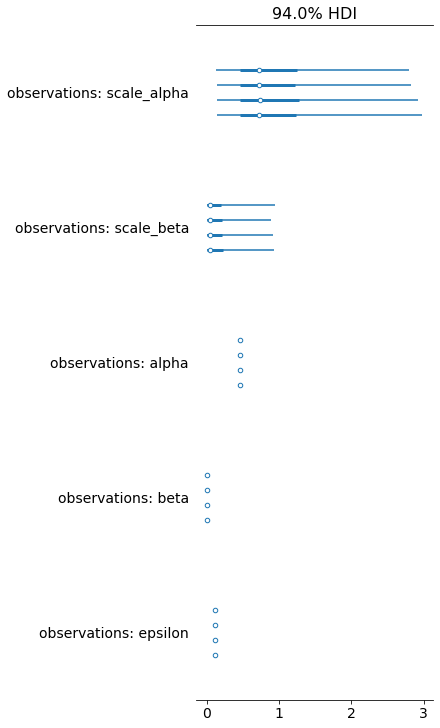

In [196]:
az.plot_forest([trace], model_names=["observations"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017E2238BFD0>,
      dtype=object)

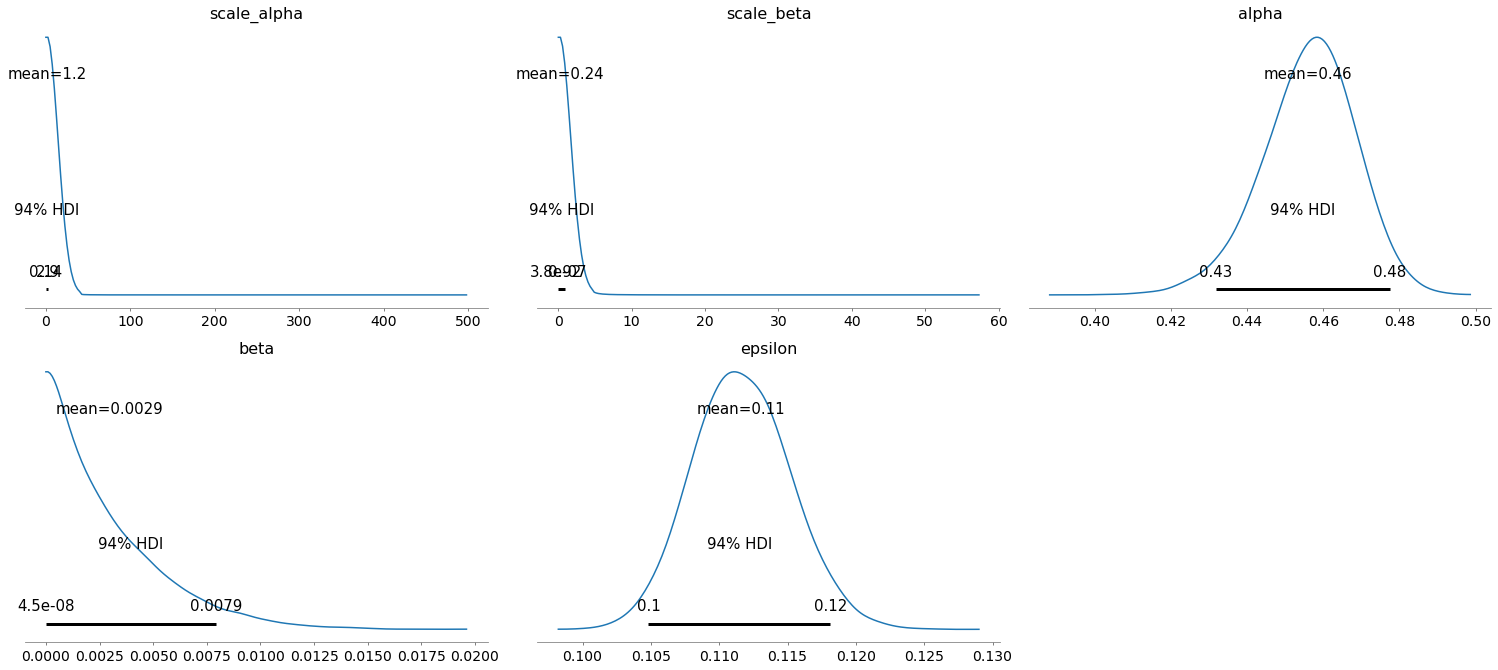

In [197]:
az.plot_posterior(trace)

In [198]:
az.summary(inference_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
scale_alpha,1.174,2.591,0.137,2.884,0.020,0.014,16695.0,16695.0,20251.0,20438.0,1.0
scale_beta,0.241,0.845,0.000,0.918,0.006,0.004,23385.0,21350.0,14561.0,14134.0,1.0
alpha,0.456,0.012,0.432,0.477,0.000,0.000,5917.0,5917.0,6185.0,7236.0,1.0
beta,0.003,0.003,0.000,0.008,0.000,0.000,5180.0,4959.0,5376.0,6369.0,1.0
epsilon,0.112,0.004,0.105,0.118,0.000,0.000,15744.0,15713.0,15823.0,17166.0,1.0


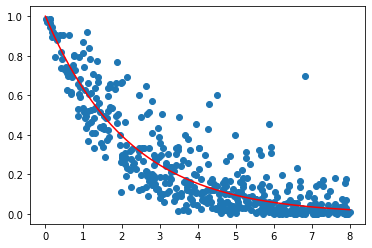

In [188]:
# Taking the output alpha and beta values to plot against the fake observed data.

w=np.linspace(0,8,1000)
def function(thing):
    v=np.exp((-1)*((0.456*w)+(0.003*w**2)))
    return v
v=function(w)
plt.scatter(ex,ey)

plt.plot(w,v, color='r')